# Multi-agent Systems with Mistral AI, Milvus and Llama-agents

# Goal of this Notebook

In this Notebook, we will explore different ideas: 

### 1️⃣ Store Data into Milvus:
Learn to store data into Milvus, an efficient vector database designed for high-speed similarity searches and AI applications.

### 2️⃣ Use llama-index with Mistral Models for Data Queries:
Discover how to use llama-index in combination with Mistral models to query data stored in Milvus.

### 3️⃣ Create Automated Data Search and Reading Agents:
Build agents that can automatically search and read data based on user queries. These automated agents will enhance user experience by delivering quick, accurate responses, reducing manual search effort.

### 4️⃣ Develop Agents for Metadata Filtering Based on User Queries:
Implement agents that can automatically generate metadata filters from user queries, refining and contextualising search results, avoiding  confusion and enhancing the accuracy of information retrieved, even for complex queries.

# 🔍 Summary
By the end of this notebook, you’ll have a comprehensive understanding of using Milvus, llama-index with llama-agents, and Mistral models to build a robust and efficient data retrieval system.

--- 

# Milvus
Milvus is an open-source vector database that powers AI applications with vector embeddings and similarity search.

In this notebook, we use Milvus Lite, it is the lightweight version of Milvus.

With Milvus Lite, you can start building an AI application with vector similarity search within minutes! Milvus Lite is good for running in the following environment:

* Jupyter Notebook / Google Colab
* Laptops
* Edge Devices

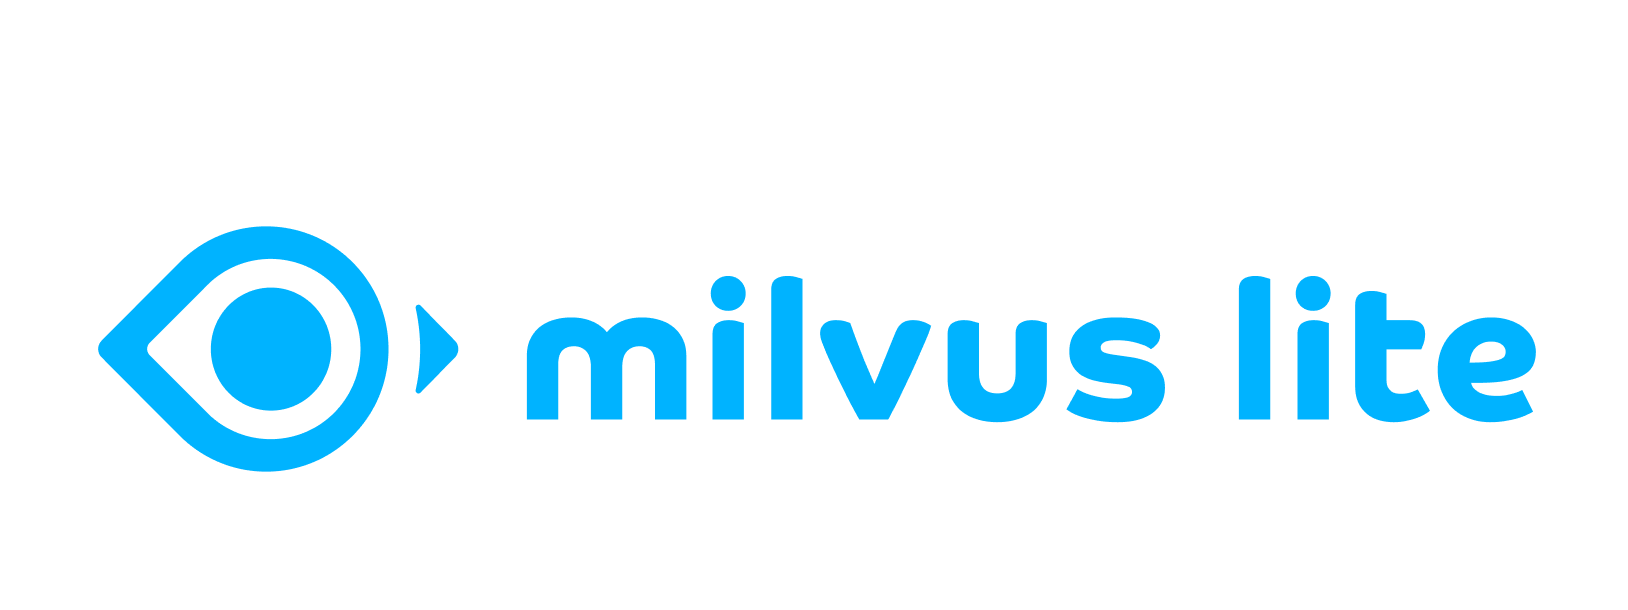

# llama-agents
`llama-agents` makes it possible to run agents as microservices. That makes it possible to scale services up and down.

# llama-index
LlamaIndex  is a data framework for your LLM application. It provides tools like: 
* Data connectors ingest your existing data from their native source and format.
* Data indexes structure your data in intermediate representations that are easy and performant for LLMs to consume.
* Engines provide natural language access to your data.
* Agents are LLM-powered knowledge workers augmented by tools, from simple helper functions to API integrations and more.




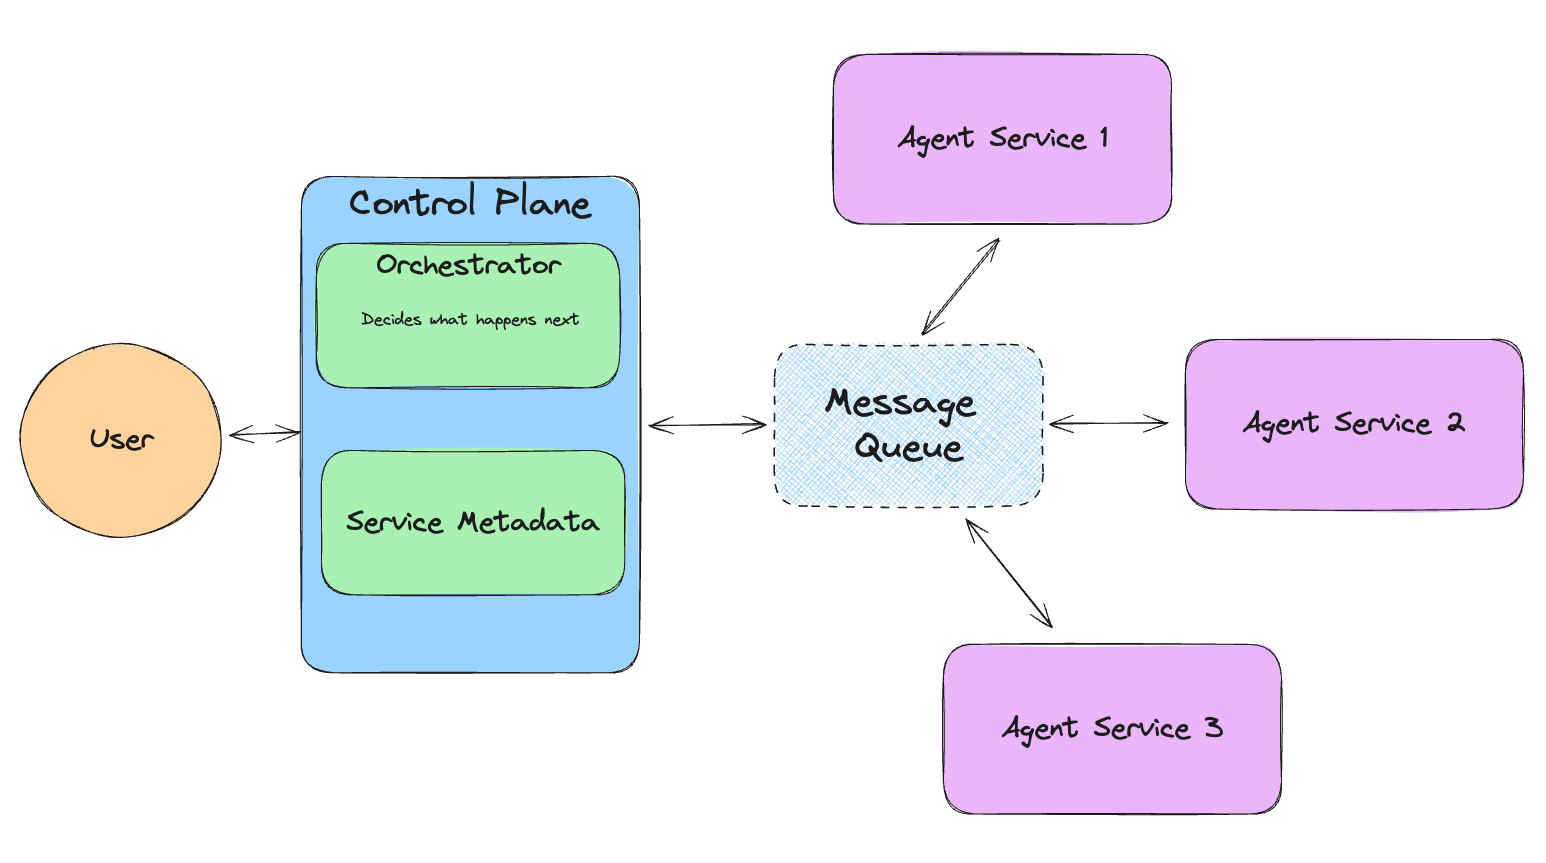

# Mistral AI

Mistral AI is a research lab building LLMs and Embeddings Models, they recently released new versions of their models, Mistral Nemo and Mistral Large which have shown to be particularly good in RAG and function calling. Because of that, we are going to use them in this notebook 

----

# Install Dependencies

In [ ]:
! pip install llama-agents pymilvus openai python-dotenv

In [ ]:
! pip install llama-index-vector-stores-milvus llama-index-readers-file llama-index-llms-ollama llama-index-llms-mistralai llama-index-embeddings-mistralai

In [25]:
# NOTE: This is ONLY necessary in jupyter notebook.
# Details: Jupyter runs an event-loop behind the scenes.
#          This results in nested event-loops when we start an event-loop to make async queries.
#          This is normally not allowed, we use nest_asyncio to allow it for convenience.
import nest_asyncio

nest_asyncio.apply()

### Get your API Key for Mistral on https://console.mistral.ai/api-keys/

In [2]:
"""
load_dotenv reads key-value pairs from a .env file and can set them as environment variables.
This is useful to avoid leaking your API key for example :D
"""

from dotenv import load_dotenv
import os

load_dotenv()

True

## Download data

In [ ]:
!mkdir -p 'data/10k/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/uber_2021.pdf' -O 'data/10k/uber_2021.pdf'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/lyft_2021.pdf' -O 'data/10k/lyft_2021.pdf'

# Prepare Embedding Model

We define the Embedding Model that will be used in this notebook. We use `mistral-embed`, it is an Embedding model developed by Mistral, it has been trained with Retrievals in mind, which makes it a very good one for our Agentic RAG system.

https://docs.mistral.ai/capabilities/embeddings/

In [3]:
from llama_index.core import Settings
from llama_index.embeddings.mistralai import MistralAIEmbedding

# Define the default Embedding model used in this Notebook.
# We are using Mistral Models, so we are also using Mistral Embeddings

Settings.embed_model = MistralAIEmbedding(model_name="mistral-embed")

# Define the LLM Model 

Llama Index uses LLMs to respond to prompts and queries, and is responsible for writing natural language responses.
We define Mistral Nemo as the default one. Nemo offers a large context window of up to 128k tokens. Its reasoning, world knowledge, and coding accuracy are state-of-the-art in its size category.

In [4]:
from llama_index.llms.ollama import Ollama

Settings.llm = Ollama("mistral-nemo")

# Instanciate Milvus and Load Data

[Milvus](https://milvus.io/) is a popular open-source vector database that powers AI applications with highly performant and scalable vector similarity search.

- Setting the uri as a local file, e.g.`./milvus.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
- If you have large scale of data, say more than a million vectors, you can set up a more performant Milvus server on [Docker or Kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your uri.
- If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the uri and token, which correspond to the [Public Endpoint and API key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#cluster-details) in Zilliz Cloud.

In [5]:
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.tools import QueryEngineTool, ToolMetadata

input_files = ["./data/10k/lyft_2021.pdf", "./data/10k/uber_2021.pdf"]

# Create a single Milvus vector store
vector_store = MilvusVectorStore(
    uri="./milvus_demo.db", dim=1024, overwrite=False, collection_name="companies_docs"
)

# Create a storage context with the Milvus vector store
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Load data
docs = SimpleDirectoryReader(input_files=input_files).load_data()

# Build index
index = VectorStoreIndex.from_documents(docs, storage_context=storage_context)

# Define the query engine
company_engine = index.as_query_engine(similarity_top_k=3)

# Define Tools 

One of the key steps in building an effective agent is defining the tools it can use to perform its tasks. These tools are essentially functions or services that the agent can call upon to retrieve information or perform actions.

Below, we'll define two tools that our agent can use to query financial information about Lyft and Uber from the year 2021. These tools will be integrated into our agent, allowing it to respond to natural language queries with precise and relevant information.

If you look at the graph we have at the top, this is what an "Agent Service" is. 

In [6]:
# Define the different tools that can be used by our Agent.
query_engine_tools = [
    QueryEngineTool(
        query_engine=company_engine,
        metadata=ToolMetadata(
            name="lyft_10k",
            description=(
                "Provides information about Lyft financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
                "Do not attempt to interpret or summarize the data."
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=company_engine,
        metadata=ToolMetadata(
            name="uber_10k",
            description=(
                "Provides information about Uber financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
                "Do not attempt to interpret or summarize the data."
            ),
        ),
    ),
]

In [7]:
from llama_index.llms.ollama import Ollama
from llama_index.llms.mistralai import MistralAI

# Set up the agent
llm = Ollama(model="mistral-nemo")

response = llm.predict_and_call(
    query_engine_tools,
    user_msg="Could you please provide a comparison between Lyft and Uber's total revenues in 2021?",
    allow_parallel_tool_calls=True,
)

# Example usage without metadata filtering
print("Response without metadata filtering:")
print(response)

Response without metadata filtering:
The revenue for Lyft in 2021 was $3.84 billion.

Uber's total revenue for the year ended December 31, 2021 was $17,455 million.


# Metadata Filtering

**Milvus** supports [Metadata filtering](https://zilliz.com/blog/json-metadata-filtering-in-milvus), a technique that allows you to refine and narrow down the search results based on specific attributes or tags associated with your data. This is particularly useful in scenarios where you have a lot of data and need to retrieve only the relevant subset of data that matches certain criteria.

## Use Cases for Metadata Filtering
* **Precision in Search Results**: By applying metadata filters, you can ensure that the search results are highly relevant to the user's query. For example, if you have a collection of financial documents, you can filter them based on the company name, year, or any other relevant metadata.

* **Efficiency**: Metadata filtering helps in reducing the amount of data that needs to be processed, making the search operations more efficient. This is especially beneficial when dealing with large datasets.

* **Customization**: Different users or applications may have different requirements. Metadata filtering allows you to customize the search results to meet specific needs, such as retrieving documents from a particular year or company.

### Example usage
In the code block below, metadata filtering is used to create a filtered query engine that retrieves documents based on a specific metadata key-value pair: `file_name`: `lyft_2021.pdf`


The `QueryEngineTool` defined below is more generic than the one defined above, in the one above, we had a tool per company (Uber and Lyft), in this one, it is more generic. We only know we have financial documents about companies but that's it. 
By adding a Metadata Filtering, we can then filter on only getting data from a specific document. 

In [16]:
from llama_index.core.vector_stores import ExactMatchFilter, MetadataFilters

# Example usage with metadata filtering
filters = MetadataFilters(
    filters=[ExactMatchFilter(key="file_name", value="lyft_2021.pdf")]
)

print(f"filters: {filters}")
filtered_query_engine = index.as_query_engine(filters=filters)

# Define query engine tools with the filtered query engine
query_engine_tools = [
    QueryEngineTool(
        query_engine=filtered_query_engine,
        metadata=ToolMetadata(
            name="company_docs",
            description=(
                "Provides information about various companies' financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
                "Use this tool to retrieve specific data points about a company. "
                "Do not attempt to interpret or summarize the data."
            ),
        ),
    ),
]

filters: filters=[MetadataFilter(key='file_name', value='lyft_2021.pdf', operator=<FilterOperator.EQ: '=='>)] condition=<FilterCondition.AND: 'and'>


# Function Calling
Mistral Nemo and Large support native function calling. There's a seamless integration with LlamaIndex tools, through the `predict_and_call` function on the llm. 
This allows the user to attach any tools and let the LLM decide which tools to call (if any).

You can learn more about Agents on the llama-index website: https://docs.llamaindex.ai/en/latest/module_guides/deploying/agents/

In [17]:
# Set up the LLM we will use for Function Calling

llm = Ollama(model="mistral-nemo")

# Interact with the Agent

Now we can the Metadata Filtering in action:
1. In the first one, the Agent shouldn't be able to find anything to the user's query as it's about Uber and we filter on Documents only about Lyft.
2. In the second one, the Agent should be able to find information about Lyft as we will only search through documents that are about Lyft. 

In [18]:
response = llm.predict_and_call(
    query_engine_tools,
    user_msg="How many employees does Uber have?",
    allow_parallel_tool_calls=True,
)
print(response)

I'm unable to provide information about Uber's employee count as it's outside the given Lyft context.


In [19]:
response = llm.predict_and_call(
    query_engine_tools,
    user_msg="What are the risk factors for Lyft?",
    allow_parallel_tool_calls=True,
)

print(response)

Investing in Lyft carries significant risks. These include general economic factors like impacts from pandemics or crises, operational factors such as competition, pricing changes, and driver/ride growth unpredictability, insurance coverage issues, autonomous vehicle technology uncertainties, reputational concerns, potential security breaches, reliance on third-party services, and challenges in expanding platform offerings. Lyft's business operations are subject to numerous other risks not explicitly mentioned here, which could also harm its financial condition and prospects.


----

# Example of Confusion Without Metadata Filtering
```
> Question: What are the risk factors for Uber?

> Response without metadata filtering:
Based on the provided context, which pertains to Lyft's Risk Factors section in their Annual Report, some of the potential risk factors applicable to a company like Uber might include:

- General economic factors such as the impact of global pandemics or other crises on ride-sharing demand.
- Operational factors like competition in ride-hailing services, unpredictability in results of operations, and uncertainty about market growth for ridesharing and related services.
- Risks related to attracting and retaining qualified drivers and riders.
```

In this example, the system incorrectly provides information about Lyft instead of Uber, leading to a misleading response. It starts by saying that it doens't have the information but then just goes on and on.

# Using an Agent to Extract Metadata Filters

To address this issue, we can use an agent to automatically extract metadata filters from the user's question and apply them during the question answering process. This ensures that the system retrieves the correct and relevant information.

## Code Example
Below is a code example that demonstrates how to create a filtered query engine using an agent to extract metadata filters from the user's question:

### Explanation
* **Prompt Template**: The PromptTemplate class is used to define a template for extracting metadata filters from the user's question. The template instructs the language model to consider company names, years, and other relevant attributes.

* **LLM**: Mistral Nemo is used to generate the metadata filters based on the user's question. The model is prompted with the question and the template to extract the relevant filters.

* **Metadata Filters**: The response from the LLM is parsed to create a `MetadataFilters` object. If no specific filters are mentioned, an empty `MetadataFilters` object is returned.

* **Filtered Query Engine**: The `index.as_query_engine(filters=metadata_filters)` method creates a query engine that applies the extracted metadata filters to the index. This ensures that only the documents matching the filter criteria are retrieved.

In [12]:
from llama_index.core.prompts.base import PromptTemplate


# Function to create a filtered query engine
def create_query_engine(question):
    # Extract metadata filters from question using a language model
    prompt_template = PromptTemplate(
        "Given the following question, extract relevant metadata filters.\n"
        "Consider company names, years, and any other relevant attributes.\n"
        "Don't write any other text, just the MetadataFilters object"
        "Format it by creating a MetadataFilters like shown in the following\n"
        "MetadataFilters(filters=[ExactMatchFilter(key='file_name', value='lyft_2021.pdf')])\n"
        "If no specific filters are mentioned, returns an empty MetadataFilters()\n"
        "Question: {question}\n"
        "Metadata Filters:\n"
    )

    prompt = prompt_template.format(question=question)
    llm = Ollama(model="mistral-nemo")
    response = llm.complete(prompt)

    metadata_filters_str = response.text.strip()
    if metadata_filters_str:
        metadata_filters = eval(metadata_filters_str)
        print(f"eval: {metadata_filters}")
        return index.as_query_engine(filters=metadata_filters)
    return index.as_query_engine()

In [13]:
response = create_query_engine(
    "What is Uber revenue? This should be in the file_name: uber_2021.pdf"
)

eval: filters=[MetadataFilter(key='file_name', value='uber_2021.pdf', operator=<FilterOperator.EQ: '=='>)] condition=<FilterCondition.AND: 'and'>


In [14]:
## Example usage with metadata filtering
question = "What is Uber revenue? This should be in the file_name: uber_2021.pdf"
filtered_query_engine = create_query_engine(question)

# Define query engine tools with the filtered query engine
query_engine_tools = [
    QueryEngineTool(
        query_engine=filtered_query_engine,
        metadata=ToolMetadata(
            name="company_docs_filtering",
            description=(
                "Provides information about various companies' financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
]
# Set up the agent with the updated query engine tools
response = llm.predict_and_call(
    query_engine_tools,
    user_msg=question,
    allow_parallel_tool_calls=True,
)

print("Response with metadata filtering:")
print(response)

eval: filters=[MetadataFilter(key='file_name', value='uber_2021.pdf', operator=<FilterOperator.EQ: '=='>)] condition=<FilterCondition.AND: 'and'>
Response with metadata filtering:
Uber's total revenue for the year ended December 31, 2021, is $17.455 billion.


# Orchestrating the different services with Mistral Large

Mistral Large is the flagship model of Mistral with very good reasoning, knowledge, and coding capabilities. It's ideal for complex tasks that require large reasoning capabilities or are highly specialized. It has advanced function calling capabilities, which is exactly what we need to orchestrate our different agents.

## Why do we need a smarter Model? 
The question being answered below is particularly challenging because it requires the orchestration of multiple services and agents to provide a coherent and accurate response. This involves coordinating various tools and agents to retrieve and process information from different sources, such as financial data from different companies.

### What's so difficult about that? 
* Complexity: The question involves multiple agents and services, each with its own functionality and data sources. Coordinating these agents to work together seamlessly is a complex task.

* Data Integration: The question requires integrating data from different sources, which can be challenging due to variations in data formats, structures, and metadata.

* Contextual Understanding: The question may require understanding the context and relationships between different pieces of information, which is a cognitively demanding task.

## Why would Mistral Large help in this case?
Mistral Large is well-suited for this task due to its advanced reasoning and function calling capabilities. Here’s how it helps:


* Advanced Reasoning: Mistral Large can handle complex reasoning tasks, making it ideal for orchestrating multiple agents and services. It can understand the relationships between different pieces of information and make informed decisions.

* Function Calling Capabilities: Mistral Large has advanced function calling capabilities, which are essential for coordinating the actions of different agents. This allows for seamless integration and orchestration of various services.

* Specialized Knowledge: Mistral Large is designed for highly specialized tasks, making it well-suited for handling complex queries that require deep domain knowledge.


For all those reasons, I decided that using Mistral Large instead of Mistral Nemo was better suited here. 

In [20]:
from llama_agents import (
    AgentService,
    ToolService,
    LocalLauncher,
    MetaServiceTool,
    ControlPlaneServer,
    SimpleMessageQueue,
    AgentOrchestrator,
)

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.llms.mistralai import MistralAI

# create our multi-agent framework components
message_queue = SimpleMessageQueue()
control_plane = ControlPlaneServer(
    message_queue=message_queue,
    orchestrator=AgentOrchestrator(llm=MistralAI("mistral-large-latest")),
)

# define Tool Service
tool_service = ToolService(
    message_queue=message_queue,
    tools=query_engine_tools,
    running=True,
    step_interval=0.5,
)

# define meta-tools here
meta_tools = [
    await MetaServiceTool.from_tool_service(
        t.metadata.name,
        message_queue=message_queue,
        tool_service=tool_service,
    )
    for t in query_engine_tools
]

# define Agent and agent service
worker1 = FunctionCallingAgentWorker.from_tools(
    meta_tools, llm=MistralAI("mistral-large-latest")
)

agent1 = worker1.as_agent()
agent_server_1 = AgentService(
    agent=agent1,
    message_queue=message_queue,
    description="Used to answer questions over differnet companies for their Financial results",
    service_name="Companies_analyst_agent",
)

In [21]:
import logging

# change logging level to enable or disable more verbose logging
logging.getLogger("llama_agents").setLevel(logging.INFO)

In [22]:
## Define Launcher
launcher = LocalLauncher(
    [agent_server_1, tool_service],
    control_plane,
    message_queue,
)

In [23]:
query_str = "What are the risk factors for Uber?"
result = launcher.launch_single(query_str)

INFO:llama_agents.message_queues.simple - Consumer AgentService-27cde4ed-5163-4005-90fc-13c158eda7e3: Companies_analyst_agent has been registered.
INFO:llama_agents.message_queues.simple - Consumer ToolService-b73c500a-5fbe-4f57-95c7-db74e173bd1b: default_tool_service has been registered.
INFO:llama_agents.message_queues.simple - Consumer 62465ab8-32ff-436e-95fa-74e828745150: human has been registered.
INFO:llama_agents.message_queues.simple - Consumer ControlPlaneServer-f4c27d43-5474-43ca-93ca-a9aeed4534d7: control_plane has been registered.
INFO:llama_agents.services.agent - Companies_analyst_agent launch_local
INFO:llama_agents.message_queues.base - Publishing message to 'control_plane' with action 'ActionTypes.NEW_TASK'
INFO:llama_agents.message_queues.simple - Launching message queue locally
INFO:llama_agents.services.agent - Processing initiated.
INFO:llama_agents.services.tool - Processing initiated.
INFO:llama_agents.message_queues.base - Publishing message to 'Companies_analys

In [24]:
print(result)

[{"name": "finalize", "arguments": {"input": "Uber faces several risk factors, including general economic impacts such as pandemics or downturns, operational challenges like competition, market growth uncertainty, attracting and retaining drivers and riders, insurance adequacy, autonomous vehicle technology development, maintaining its reputation and brand, and managing growth. Additionally, reliance on third-party providers for various services can introduce further risks to its operations."}}]


# Conclusion

In this notebook, you have seen how you can use llama-agents to perform different actions by calling appropriate tools. By using Mistral Large in combination with Mistral Nemo, we demonstrated how to effectively orchestrate intelligent, resource-efficient systems by leveraging the strengths of different LLMs. We saw that the Agent could pick the collection containing the data requested by the user. 
